In [8]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)
fs = 250
N = 5000
dt = 1./fs
time = np.arange(N)*dt

SNR_f = 20 # 20dB pomeni, da je razmerje med varianco signala in šuma 10
SNR_x = 20

σ_u = 1
σ_m = σ_u/10**(SNR_f/20) # na podlagi definirije 20*np.log10(σ_u/σ_m)

u = rng.normal(size=N, scale=σ_u)
m = rng.normal(size=N, scale=σ_m)

f = u + m # pomerjeno vzbujanje v času

scale = 1.0 / (fs*N)
U = np.fft.rfft(u) # dejansko vzbujanje sistema
F = np.fft.rfft(f) # pomerjeno vzbujanje sistema
freq = np.fft.rfftfreq(N, d=dt)

G_uu = 2*scale*np.abs(U.conj()*U)
G_ff = 2*scale*np.abs(F.conj()*F)

def alpha(freq, m, k, c):
    """
    Frekvenčna prenosna funkcija linearnega oscilatorja.
    """
    omega = 2*np.pi*freq
    return 1 / (-omega**2*m + 1j*omega*c + k)

H = alpha(freq, m=1,k=1e5,c=10)
V = H*U                      #odziv brez šuma
v = np.fft.irfft(V)        # dejanski odziv v času
σ_n = np.std(v)/10**(SNR_x/20) # na podlagi definirije 20*np.log10(σ_v/σ_n)
n = rng.normal(size=N, scale=σ_n)

x = v + n            # pomerjen odziv sistema
X = np.fft.rfft(x) # pomerjeno vzbujanje sistema

G_fx = 2*scale*F.conj()*X
G_xx = 2*scale*np.abs(X.conj()*X)
G_xf = G_fx.conj()

H1 = G_fx/G_ff
H2 = G_xx/G_xf
γ2 = np.abs(H1/H2)

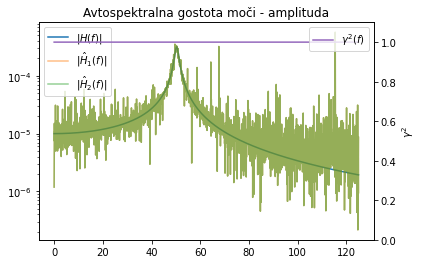

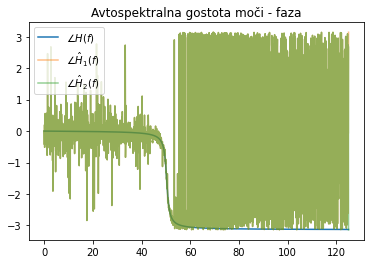

In [9]:
fig, ax = plt.subplots()
ax.set_title('Avtospektralna gostota moči - amplituda')
ax.semilogy(freq, np.abs(H), label='$|H(f)|$')
ax.semilogy(freq, np.abs(H1), label='$|\\hat H_1(f)|$', alpha=0.5)
ax.semilogy(freq, np.abs(H2), label='$|\\hat H_2(f)|$', alpha=0.5)
ax.legend(loc=2)
ax2 = ax.twinx() 
ax2.plot(freq, γ2, 'C4', label='$\\gamma^2(f)$')
ax2.set_xlabel('f [Hz]')
ax2.set_ylabel('$\\gamma^2$')
ax2.set_ylim(0,1.1)
ax2.legend(loc=1)
plt.show()

fig, ax = plt.subplots()
ax.set_title('Avtospektralna gostota moči - faza')
ax.plot(freq, np.angle(H), label='$\\angle H(f)$')
ax.plot(freq, np.angle(H1), label='$\\angle\\hat H_1(f)$', alpha=0.5)
ax.plot(freq, np.angle(H2), label='$\\angle\\hat H_2(f)$', alpha=0.5)
ax.legend()
plt.show()

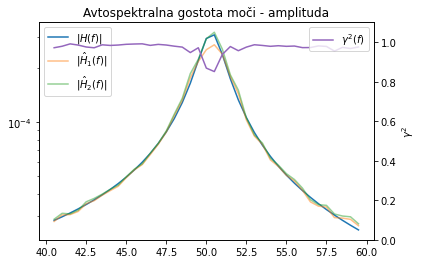

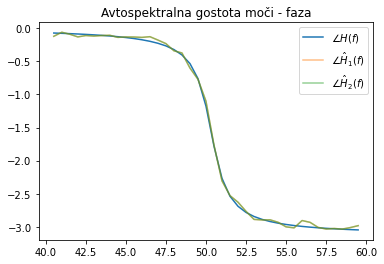

In [11]:
from scipy import signal

odsekov = 10
N_ = N//odsekov
win = signal.windows.hann(N_)              # okno
scale = 1.0 / (fs*(win*win).sum())

G_fx = np.zeros(N_//2+1, dtype=complex) #brisanje
G_ff = np.zeros(N_//2+1, dtype=complex)
G_xf = np.zeros(N_//2+1, dtype=complex)
G_xx = np.zeros(N_//2+1, dtype=complex)


for i in range(odsekov):
    f_ = f[i*N_:(i+1)*N_]
    x_ = x[i*N_:(i+1)*N_]
    f_w = win*f_          # okno
    x_w = win*x_
    F = np.fft.rfft(f_w)  #fft
    X = np.fft.rfft(x_w)
    G_fx += scale*2*np.conj(F) * X / odsekov #povprečiti je potrebno cenilke avto in križnega spektra
    G_ff += scale*2*np.conj(F) * F / odsekov 
    G_xf += scale*2*np.conj(X) * F / odsekov 
    G_xx += scale*2*np.conj(X) * X / odsekov

freq = np.fft.rfftfreq(N_, d=dt)
H = alpha(freq, m=1, k=1e5, c=10)

H1 = G_fx/G_ff
H2 = G_xx/G_xf
γ2 = np.abs(H1/H2)

sel = freq>=0
sel = np.logical_and(freq>40, freq<60)    # za ogled dogajanja v lastni frekvenci
fig, ax = plt.subplots()
ax.set_title('Avtospektralna gostota moči - amplituda')
ax.semilogy(freq[sel], np.abs(H[sel]), label='$|H(f)|$')
ax.semilogy(freq[sel], np.abs(H1[sel]), label='$|\\hat H_1(f)|$', alpha=0.5)
ax.semilogy(freq[sel], np.abs(H2[sel]), label='$|\\hat H_2(f)|$', alpha=0.5)
ax.legend(loc=2)
ax2 = ax.twinx() 
ax2.plot(freq[sel], γ2[sel], 'C4', label='$\\gamma^2(f)$')
ax2.set_xlabel('f [Hz]')
ax2.set_ylabel('$\\gamma^2$')
ax2.set_ylim(0,1.1)
ax2.legend(loc=1)
plt.show()

fig, ax = plt.subplots()
ax.set_title('Avtospektralna gostota moči - faza')
ax.plot(freq[sel], np.angle(H[sel]), label='$\\angle H(f)$')
ax.plot(freq[sel], np.angle(H1[sel]), label='$\\angle\\hat H_1(f)$', alpha=0.5)
ax.plot(freq[sel], np.angle(H2[sel]), label='$\\angle\\hat H_2(f)$', alpha=0.5)
ax.legend()
plt.show()